# Hipótesis 4

#### "Las provincias situadas en el sur de España (aquellas al sur de Madrid) tienden a utilizar menos dispositivos de aprovechamiento de energía renovable que las del norte." 

Las diferencias climáticas entre el norte y sur de España pueden ser una variable crucial a la hora de instalar dispositivos de energía renovable pero no la única. El clima influye en la cantidad de energía que se puede producir pero también en la que se consume.

Además puede influir el ámbito socioeconómico, las provincias con mayor poder adquisitivo podrían gastarse más en energía renovable o las más pobres podrían estar motivadas por el ahorro en la factura de la luz. Otras posibles factores de influencia, pueden ser los tamaños familiares o la edad.

## Preparación del entorno

In [72]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, DistanceMetric

GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")

import warnings
warnings.filterwarnings("ignore")

## Datos

Los datos tendrá como base la tarjeta de datos 4 (`data_card_4_df.csv`), de la que se eliminará la variable edad para añadir la variable de `Edad media` de la tarjeta de datos 1 (`data_card_1_df.csv`).

La mediana es una medida más representativa que la media, al no estar influida por valores extremos. Sin embargo, en este caso, la forma de calcular la mediana en el paso de preprocesamiento, hace que la variable de edad esté segmentada en: 42, 47 y 52 años. Por esto, se ha decidido utilizar la media, con valores continuos, y comparar los resultados con los obtenidos usando la mediana.

In [73]:
# cargar los datos
df1 = pd.read_csv(GOLD_DATA_PATH + "data_card_1_df.csv", sep=";", encoding = 'latin')

df4 = pd.read_csv(GOLD_DATA_PATH + "data_card_4_df.csv", sep=";", encoding = 'latin')
df4.drop(columns=["Unnamed: 0"], inplace=True)

In [74]:
# comprobamos valores de edad mediana
print("Valores de la columna de edad mediana: ",df4['Mediana edad'].unique())
print("Valores de la columna de edad media: ",df1['Edad media'].unique())
df4.drop(columns=["Mediana edad"], inplace=True)

Valores de la columna de edad mediana:  [47 42 52]
Valores de la columna de edad media:  [43.67752322 43.76688925 40.32044849 44.56569142 48.68338964 43.78070111
 42.89217781 46.10324759 46.68604543 45.91393265 43.51042471 44.06624206
 47.24261334 45.9213124  46.53167185 42.21228508 43.69378508 45.1453981
 42.24367027 42.74662549 41.69619621 42.09964389 45.25832978 43.76587026
 49.24604232 43.24068113 49.98722796 42.52777299 40.69691124 42.41661504
 43.27407369 50.72758972 48.2027872  46.04912329 44.45862354 48.31173251
 45.84952829 41.71263395 47.28416896 42.88057706 46.11338258 42.21760228
 43.40447056 46.25052754 51.06958706 44.53106149 47.8660301 ]


In [75]:
# sustituir la variable edad
df4 = pd.concat([df4, df1['Edad media']], axis=1)
df4.set_index('Provincias', inplace=True)

In [76]:
df4.head()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
Provincias,,,,,,,,,,
Albacete,4.314062,29549.0,136.528958,0.033132,0.072565,0.044648,0.356690,0.204834,0.288130,43.677523
Alicante/Alacant,4.036060,27540.0,135.823750,0.041038,0.094143,0.045081,0.394342,0.197734,0.227663,43.766889
Almería,6.713842,27301.0,140.478389,0.030276,0.090071,0.042470,0.349780,0.201309,0.286094,40.320448
Araba/Álava,10.445424,36848.0,107.768333,0.033775,0.097398,0.045232,0.401223,0.194786,0.227587,44.565691
Asturias,5.031368,31841.0,92.622917,0.056932,0.115216,0.035539,0.432127,0.211392,0.148794,48.683390


## Análisis de datos con clasificación manual

En principio, consideramos la siguiente división de provincias en el norte y sur de España:

In [77]:
norte=['Araba/Álava', 'Asturias', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria', 'Coruña, A', 'Gipuzkoa', 'Girona', 'Guadalajara', 'Huesca', 'León', 'Lleida', 'Lugo', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Rioja, La', 'Salamanca', 'Segovia', 'Soria', 'Tarragona', 'Teruel', 'Valladolid', 'Zamora', 'Zaragoza', 'Ávila']

df4['Grupo'] = [0 if x in norte else 1 for x in df4.index]

In [78]:
df4.groupby('Grupo').mean()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
Grupo,,,,,,,,,,
0,5.155543,33132.964286,118.608126,0.043806,0.092551,0.038844,0.401841,0.207682,0.215275,46.134766
1,5.732830,29330.842105,135.241652,0.035833,0.083094,0.042401,0.367766,0.205703,0.265203,43.108917


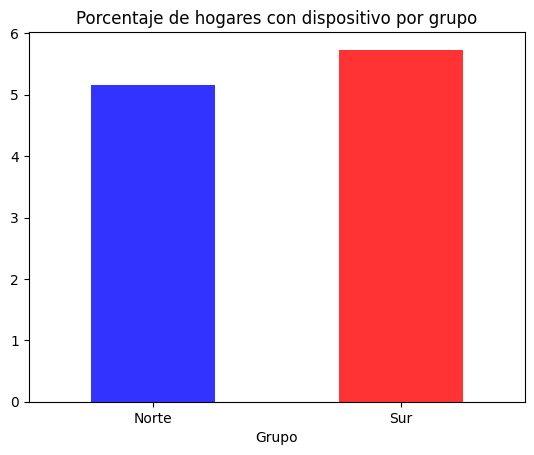

In [79]:
mean_dispositivo = df4.groupby('Grupo').mean()['Porcentaje con dispositivo']
mean_dispositivo.plot(kind='bar', color=['blue', 'red'], alpha=0.8)
plt.title('Porcentaje de hogares con dispositivo por grupo')
plt.xticks([0, 1], ['Norte', 'Sur'], rotation=0)
plt.show()

Los datos muestran que la implantación de energías renovables es muy similar, aunque en el sur es mayor. Sin embargo, la división hecha puede no ser la más adecuada ya que el criterio de división es muy subjetivo. Por ello, se realizará un análisis de clustering para determinar la división más adecuada.

In [80]:
df4.drop(columns=['Grupo'], inplace=True)

## Estandarización de los datos

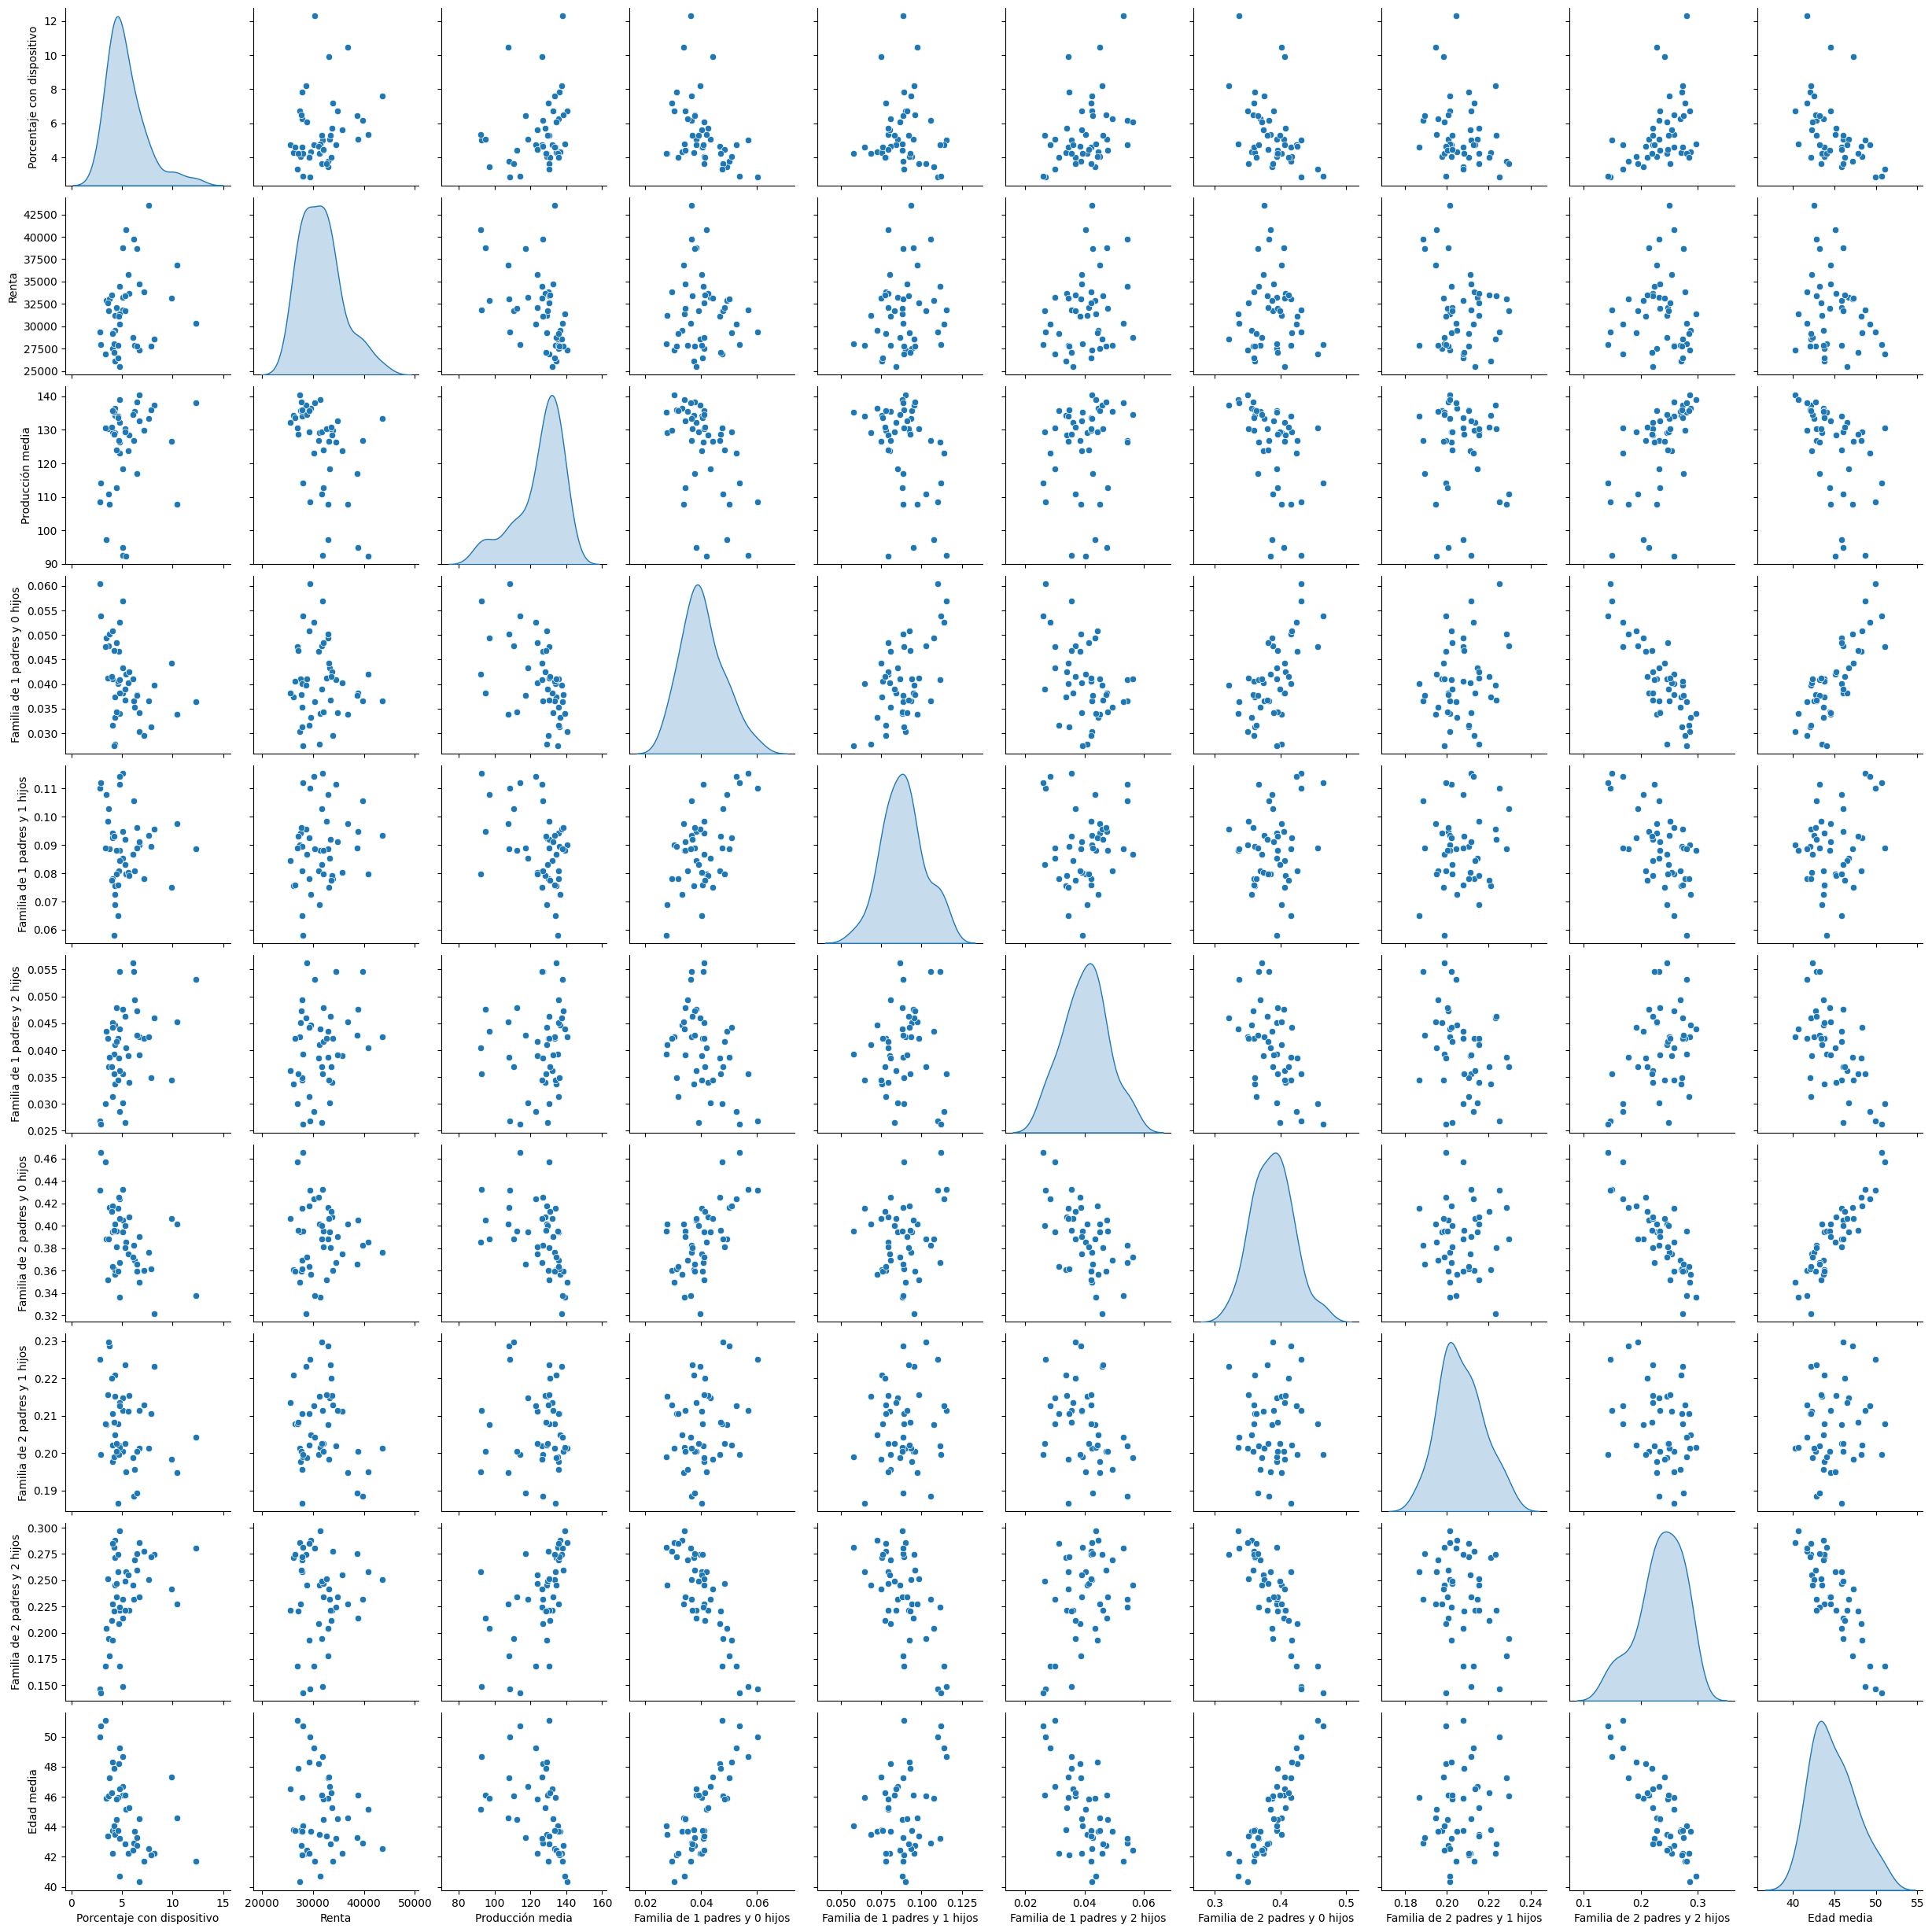

In [81]:
sns.pairplot(df4, diag_kind='kde')

Cada variable tiene una escala diferente, por lo que es necesario estandarizar los datos para que todas tengan la misma importancia en el análisis.
Se ha elegido el MinMaxScaler para que los valores estén entre 0 y 1, intentando modificar lo menos posible la distribución de los datos.

In [82]:
# Escalado de los datos a un rango de 0 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df4)
df4_scaled = pd.DataFrame(scaled_data, columns=df4.columns, index=df4.index)

df4_scaled.head(3)

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
Provincias,,,,,,,,,,
Albacete,0.157519,0.226017,0.918039,0.171973,0.252788,0.614710,0.245278,0.422595,0.943885,0.312311
Alicante/Alacant,0.128196,0.114808,0.903404,0.412220,0.630817,0.629123,0.506302,0.258196,0.550791,0.320625
Almería,0.410642,0.101578,1.000000,0.085170,0.559481,0.542252,0.197373,0.340967,0.930649,0.000000


## Análisis de componentes principales

Para reducir la dimensionalidad de los datos y poder visualizarlos, se aplicará PCA con 2 componentes.

In [83]:
# Calculo de PCA
from sklearn.decomposition import PCA

estimator = PCA(n_components=2)
X_pca = estimator.fit_transform(scaled_data)

print("Porcentaje de varianza explicado por cada componente:\n", estimator.explained_variance_ratio_)
pd.DataFrame(np.matrix.transpose(estimator.components_), index=df4.columns)

Porcentaje de varianza explicado por cada componente:
 [0.46993859 0.18378319]


,0,1
Porcentaje con dispositivo,0.205603,0.220431
Renta,0.008813,0.569415
Producción media,0.336520,-0.489870
Familia de 1 padres y 0 hijos,-0.390473,0.026589
Familia de 1 padres y 1 hijos,-0.226515,0.320956
Familia de 1 padres y 2 hijos,0.277720,0.429889
Familia de 2 padres y 0 hijos,-0.348278,-0.063164
Familia de 2 padres y 1 hijos,-0.137704,-0.273299
Familia de 2 padres y 2 hijos,0.478571,-0.072816
Edad media,-0.440690,-0.121222


Text(0.5, 1.0, 'Representación 2D de los datos')

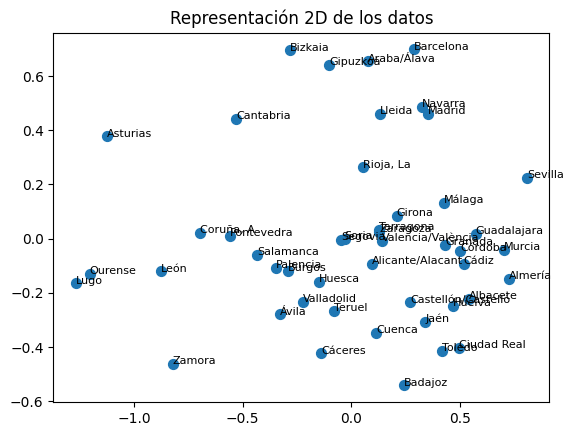

In [84]:
#Representación 2D
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], s=50)

# anotación 
for i in range(0, len(X_pca)):
    ax.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)
ax.set_title("Representación 2D de los datos")

Si se compara este gráfico con el que se obtiene con la mediana, es una versión espejada.

> 💡 **NOTA**  
> El gráfico de la mediana junto con otras técnicas de clustering que se han ejecutado para validar la hipótesis están en el archivo `h4_modeling_otros.ipynb`.

## Modelado

### Clustering jerárquico

Hemos elegido el clustering jerárquico porque es más flexible a la hora de definir los grupos, no necesita definir el número de clusters de antemano y permite ver cómo se agrupan los datos a diferentes niveles de granularidad. Además, el volumen de datos es pequeño, por lo que la complejidad computacional no es un problema.	

El clustering con KMeans es más sensible a la inicialización de los centroides, a la elección del número de clusters y a la presencia de outliers. Además, los clusters que se forman son esféricos y al tener pocos datos, no es necesario asumir esta forma, de hecho en la visualización con PCA se ve que el algoritmo ha dividido los datos simplemente por la mitad del gráfico.

Para el clustering jerárquico se usará el método de Ward, que minimiza la varianza intra-cluster. Y la métrica de distancia será la euclídea.

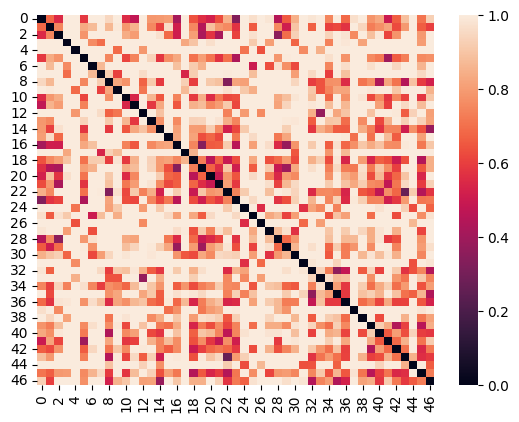

In [85]:
# distancia euclidea entre las provincias
dist = DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(scaled_data)
ax = sns.heatmap(matsim,vmin=0, vmax=1)
plt.show()

En el gráfico predominan los colores claros, lo que indica que en general, las provincias están bastante distantes entre sí. A continuación, se mostrará un dendrograma para ver la jerarquía de los clusters.

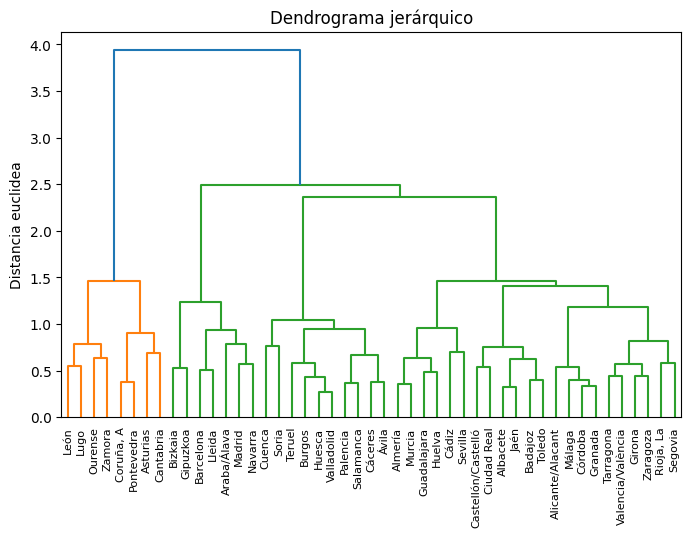

In [86]:
# metodo ward y dendrograma
link_matrix_avg = linkage(df4_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(8, 5))
dendrogram(link_matrix_avg, labels=df4_scaled.index)
plt.title('Dendrograma jerárquico')
plt.ylabel('Distancia euclidea')
plt.show()

El dendrograma muestra que hay 2 clusters. 

Se calculará el coeficiente de silhouette para evaluar la calidad del distintas configuraciones de clusters.

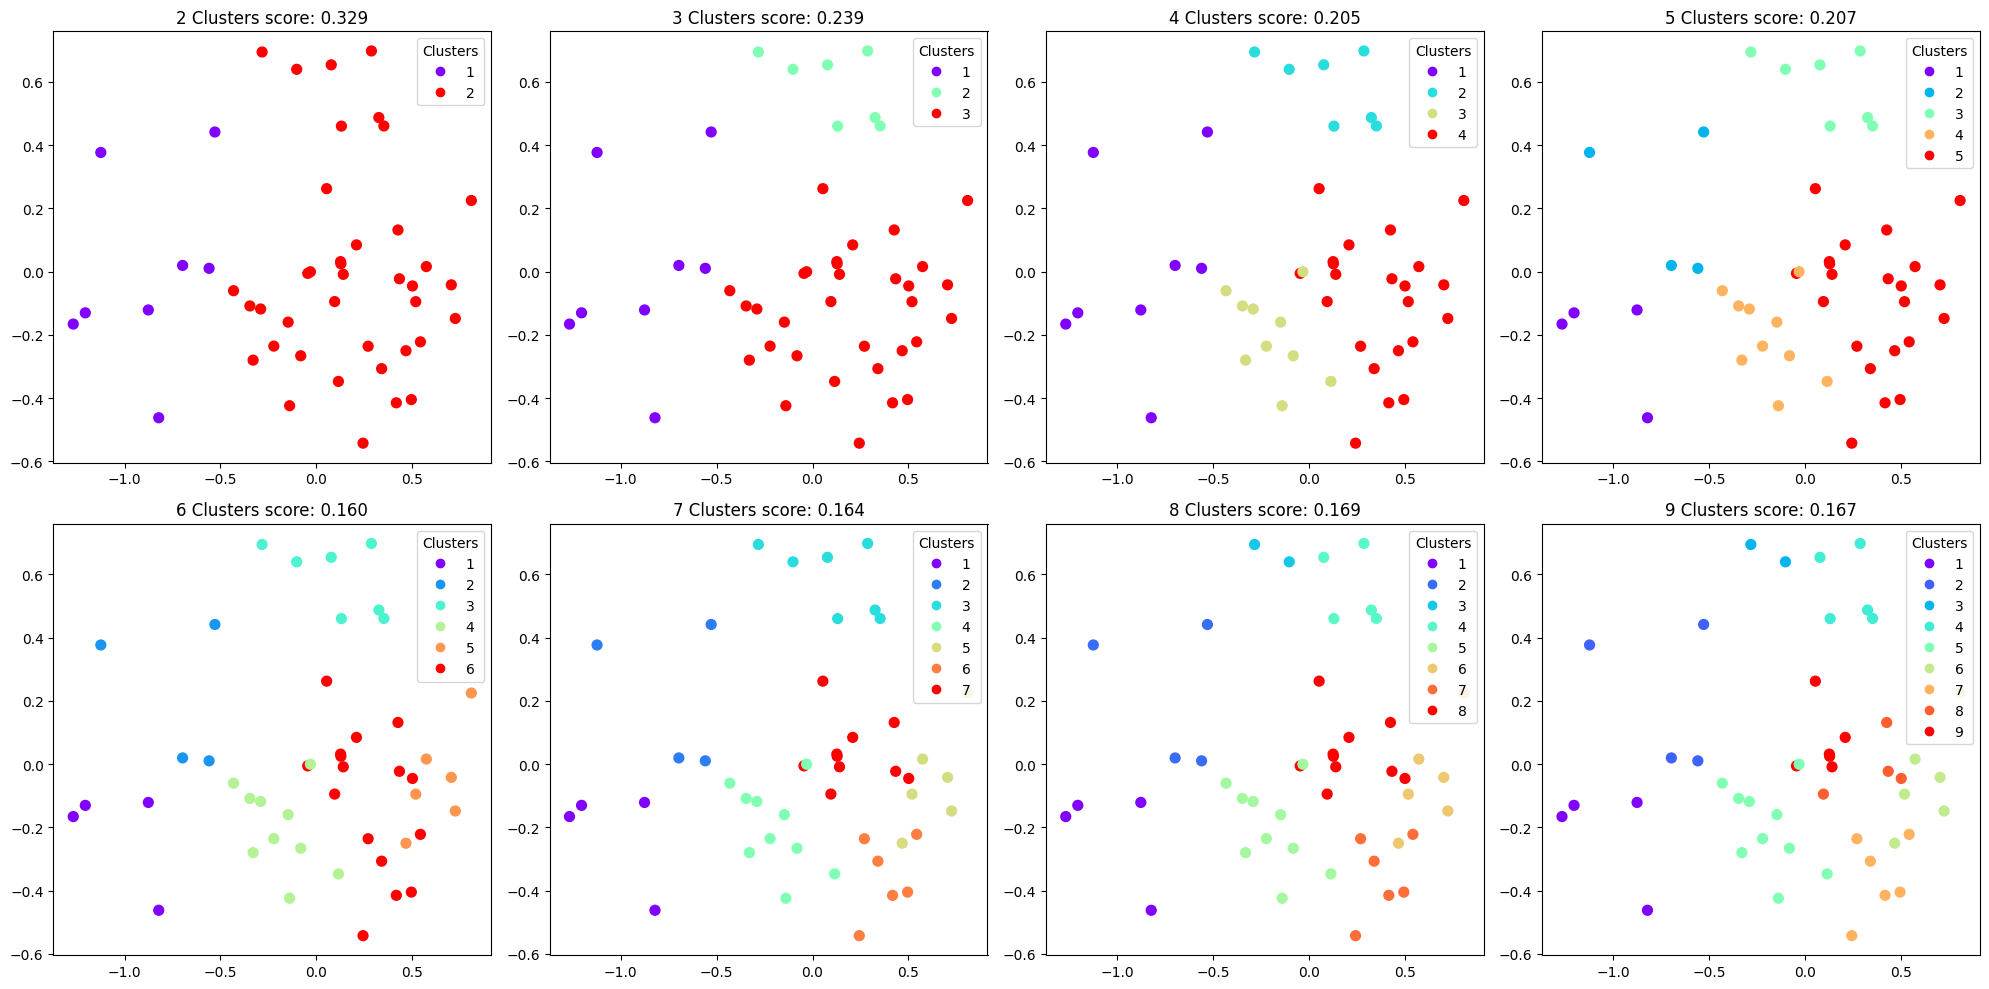

In [87]:
# Visualización de diferente número de clusters
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(2, 10):
    clusters = fcluster(link_matrix_avg, t=i, criterion='maxclust')  # Generar i clusters
    scatter = axes[i-2].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=50, cmap='rainbow')
    coef = silhouette_score(df4_scaled, clusters)
    axes[i-2].legend(*scatter.legend_elements(), title="Clusters")
    axes[i-2].set_title(f'{i} Clusters score: {coef:.3f}')

plt.tight_layout()
plt.show()

De todas las combinaciones mostradas, desde 2 a 10 clusters, el gráfico muestra que la configuración con 2 clusters es la que tiene un coeficiente de silhouette más alto, con un valor de 0.329. Aunque este valor no es muy alto, es el más alto de todos.

In [88]:
# seleccionamos 2 clusters usando el criterio de maxclust
clusters = fcluster(link_matrix_avg, t=2, criterion='maxclust')

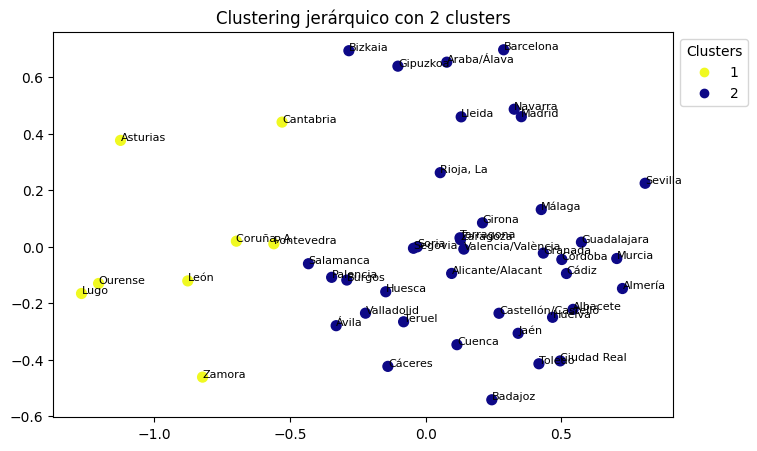

In [89]:
# visualización del resultado
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=clusters, cmap='plasma_r')

# nombres de las provincias 
for i in range(0, len(X_pca)):
    plt.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Clustering jerárquico con 2 clusters')
plt.show()

## Resultados

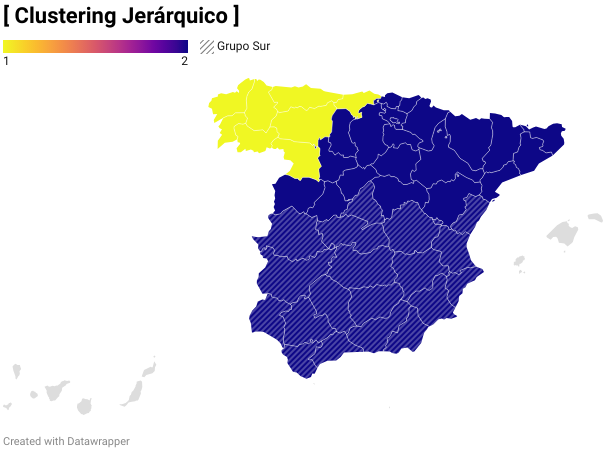

Estos resultados indican que sí se pueden agrupar las provincias en 2 grupos de norte y sur, aunque los grupos no son los que habíamos definido en la hipótesis inicial. En el mapa las provincias con una sombra gris son las que originalmente pertenencían al grupo del sur, y el resto al del norte. 

Sin embargo, los colores indican dos grupos: noroeste y el resto de la península. En el noroeste están las provincias de Asturias, Ourense, Lugo, A Coruña, Pontevedra, Cantabria, León y Zamora.

A continuación, se analizarán las características de los clusters.

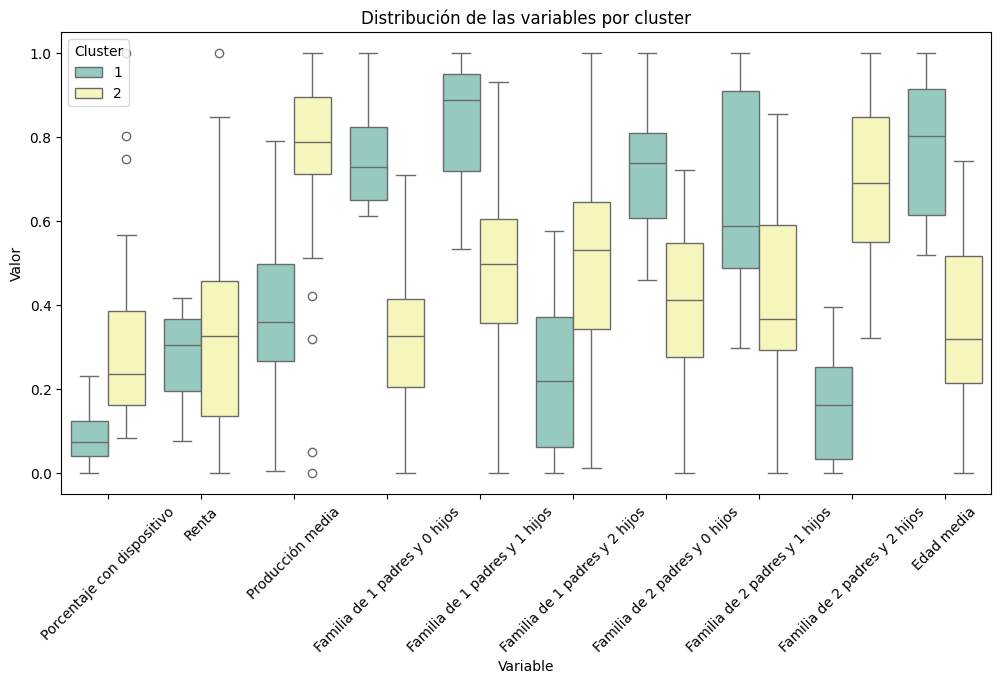

In [90]:
df4_scaled['Cluster'] = clusters
df4_melted = df4_scaled.melt(id_vars="Cluster", var_name="Variable", value_name="Valor")
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Valor", hue="Cluster", data=df4_melted, palette="Set3")
plt.title("Distribución de las variables por cluster")
plt.xticks(rotation=45)
plt.show()

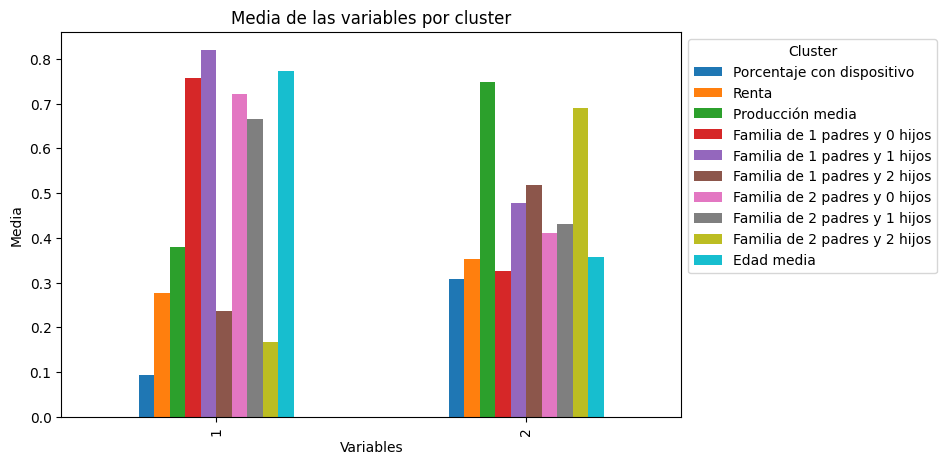

         Porcentaje con dispositivo     Renta  Producción media  \
Cluster                                                           
1                          0.092918  0.277754          0.379352   
2                          0.307399  0.351957          0.748514   

         Familia de 1 padres y 0 hijos  Familia de 1 padres y 1 hijos  \
Cluster                                                                 
1                             0.756114                       0.819270   
2                             0.325003                       0.477839   

         Familia de 1 padres y 2 hijos  Familia de 2 padres y 0 hijos  \
Cluster                                                                 
1                             0.236190                       0.721432   
2                             0.517317                       0.409743   

         Familia de 2 padres y 1 hijos  Familia de 2 padres y 2 hijos  \
Cluster                                                                 

In [91]:
df4_grouped = df4_scaled.groupby('Cluster').mean()

df4_grouped.plot(kind='bar', figsize=(8, 5))
plt.title('Media de las variables por cluster')
plt.xlabel('Variables')
plt.ylabel('Media')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.show()
print(df4_grouped)

In [92]:
df4[df4_scaled['Cluster'] == 1].describe()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media
count,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,3.701605,30483.62500,110.571591,0.052354,0.104900,0.033271,0.425373,0.215302,0.168800,48.614938
std,0.804306,2288.55606,12.412450,0.004548,0.010683,0.006305,0.028236,0.011131,0.022520,2.019083
min,2.820683,26876.00000,92.622917,0.047671,0.088605,0.026172,0.387843,0.199525,0.142937,45.913933
25%,3.209493,28992.50000,105.189015,0.048926,0.099264,0.028085,0.409139,0.207749,0.148147,46.944241
50%,3.536471,30976.50000,109.613988,0.051452,0.108884,0.032796,0.427875,0.212032,0.168161,48.964716
75%,4.006545,32109.00000,116.368033,0.054648,0.112455,0.037391,0.438409,0.225901,0.181970,50.172318
max,5.031368,33012.00000,130.486618,0.060380,0.115216,0.043495,0.465556,0.229773,0.203907,51.069587


Las características del cluster 1, las provincias del noroeste, son:
- Menor implantación de energía renovable, con una media de **3.7%** de hogares con dispositivos de energía renovable.
- Renta media por hogar ligeramente inferior al otro cluster, con una media de **30.483€**.
- Menor producción media de energía solar y con valores más dispersos (por el clima de la zona, tienen menos horas de sol).
- Mayor porcentaje de familias con 0 y 1 hijos.
- Menor porcentaje de familias con muchos hijos.
- Edad media mayor, con un valor de **48.6 años**.

## Conclusión 

Hipótesis: *"Las provincias situadas en el sur de España (aquellas al sur de Madrid) tienden a utilizar menos dispositivos de aprovechamiento de energía renovable que las del norte."*

El resultado del clustering jerárquico demuestra que la división inicial de las provincias era incorrecta y que la división ideal, si queremos comparar dos grupos, es: noroeste y resto de la península. 

Las provincias del noroeste tienen una menor implantación de energía renovable, agrupando estas provincias por: edad, climatología, tamaño de la familia y renta.

----------------------------

## Clasificación y clustering

Para verificar los resultados obtenidos, se realizará una división de las provincias en norte y sur y se etiquetarán los grupos. De esta forma, se quiere comprobar si forzando la división en 2 grupos, se obtienen los mismos resultados que con el clustering jerárquico.

In [93]:
# Provincias en el dataset
df4.index

Index(['Albacete', 'Alicante/Alacant', 'Almería', 'Araba/Álava', 'Asturias',
       'Badajoz', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria',
       'Castellón/Castelló', 'Ciudad Real', 'Coruña, A', 'Cuenca', 'Cáceres',
       'Cádiz', 'Córdoba', 'Gipuzkoa', 'Girona', 'Granada', 'Guadalajara',
       'Huelva', 'Huesca', 'Jaén', 'León', 'Lleida', 'Lugo', 'Madrid',
       'Murcia', 'Málaga', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra',
       'Rioja, La', 'Salamanca', 'Segovia', 'Sevilla', 'Soria', 'Tarragona',
       'Teruel', 'Toledo', 'Valencia/València', 'Valladolid', 'Zamora',
       'Zaragoza', 'Ávila'],
      dtype='object', name='Provincias')

In [94]:
norte=['Araba/Álava', 'Asturias', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria', 'Coruña, A', 'Gipuzkoa', 'Girona', 'Guadalajara', 'Huesca', 'León', 'Lleida', 'Lugo', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Rioja, La', 'Salamanca', 'Segovia', 'Soria', 'Tarragona', 'Teruel', 'Valladolid', 'Zamora', 'Zaragoza', 'Ávila']

df4['Grupo'] = [0 if x in norte else 1 for x in df4.index]

In [96]:
df4.head()

,Porcentaje con dispositivo,Renta,Producción media,Familia de 1 padres y 0 hijos,Familia de 1 padres y 1 hijos,Familia de 1 padres y 2 hijos,Familia de 2 padres y 0 hijos,Familia de 2 padres y 1 hijos,Familia de 2 padres y 2 hijos,Edad media,Grupo
Provincias,,,,,,,,,,,
Albacete,4.314062,29549.0,136.528958,0.033132,0.072565,0.044648,0.356690,0.204834,0.288130,43.677523,1
Alicante/Alacant,4.036060,27540.0,135.823750,0.041038,0.094143,0.045081,0.394342,0.197734,0.227663,43.766889,1
Almería,6.713842,27301.0,140.478389,0.030276,0.090071,0.042470,0.349780,0.201309,0.286094,40.320448,1
Araba/Álava,10.445424,36848.0,107.768333,0.033775,0.097398,0.045232,0.401223,0.194786,0.227587,44.565691,0
Asturias,5.031368,31841.0,92.622917,0.056932,0.115216,0.035539,0.432127,0.211392,0.148794,48.683390,0


In [97]:
df4['Grupo'].value_counts()

Grupo
0    28
1    19
Name: count, dtype: int64

## Entrenamiento y validación

Se entrenará un modelo de clasificación, en este caso se ha elegido un árbol de decisión, para extraer el valor de relevancia de cada variable y así volver a clusterizar y comparar los resultados.

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df4.drop(columns=["Grupo"])
y = df4["Grupo"]

# se divide el dataset en 30-70 para que el modelo no entrene con demasiados datos y evitar el overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 3, 4, 5, 10, 15, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 5, 6, 7],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_tree = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor score (f1-score): {grid_search.best_score_}")

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor score (f1-score): 0.8380952380952381


In [100]:
pred = best_tree.predict(X_test)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.83      0.91         6

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



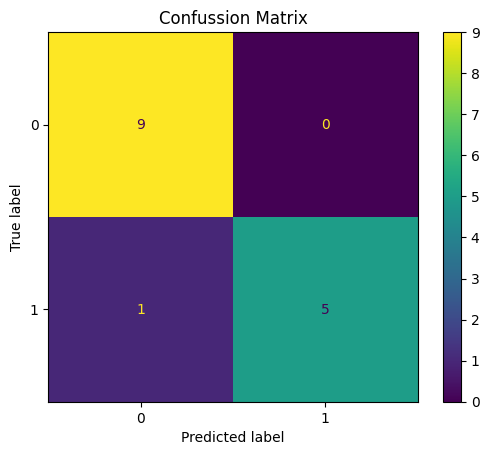

In [101]:
# Evaluación de resultados
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
cm = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
cm_display.plot()
plt.title("Confussion Matrix")
print(classification_report(y_test, pred))

El modelo muestra buenos resultados durante el entrenamiento. Pero al tener muy pocos datos, se comprobarán los resultados usando validación cruzada del tipo Leave One Out. Este tipo de validación tiene un gran coste computacional con grandes volumenes de datos, pero al tener pocos, es la mejor opción.

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

scores = cross_val_score(best_tree, X, y, cv=LeaveOneOut())
print(f"Accuracy: {scores.mean():.2f}")

Accuracy: 0.91


In [103]:
print ('================= Feature Relevances ====================')
importance = pd.DataFrame({'Attributes': X_train.columns,
            'Feature importance':best_tree.feature_importances_}).sort_values('Feature importance', ascending=False)
print(importance)

================= Feature Relevances ====================
                      Attributes  Feature importance
2               Producción media            0.765568
4  Familia de 1 padres y 1 hijos            0.123077
1                          Renta            0.111355
0     Porcentaje con dispositivo            0.000000
3  Familia de 1 padres y 0 hijos            0.000000
5  Familia de 1 padres y 2 hijos            0.000000
6  Familia de 2 padres y 0 hijos            0.000000
7  Familia de 2 padres y 1 hijos            0.000000
8  Familia de 2 padres y 2 hijos            0.000000
9                     Edad media            0.000000


In [104]:
# seleccion de las dos variables más importantes
variables = importance.iloc[:3]['Attributes'].values

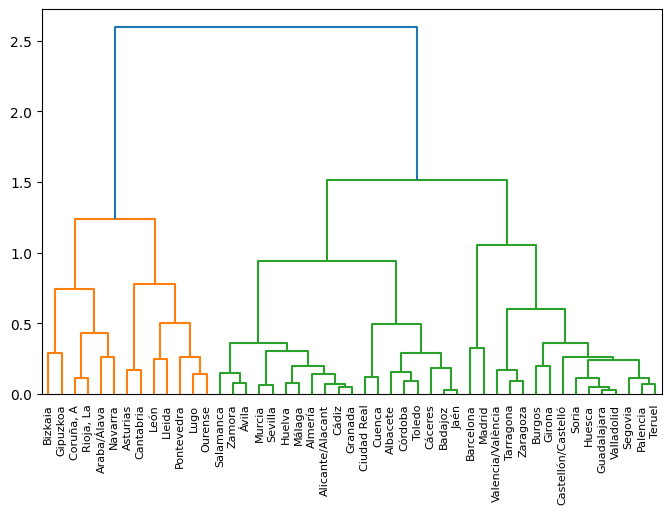

In [105]:
selection = df4_scaled[variables]

link_matrix_avg = linkage(selection, method='ward', metric='euclidean')

plt.figure(figsize=(8, 5))
dendrogram(link_matrix_avg, labels=df4.index)
plt.show()

In [106]:
clusters = fcluster(link_matrix_avg, t=2, criterion='maxclust')
print("coeficiente de silhouette: ",silhouette_score(selection, clusters))

coeficiente de silhouette:  0.4212118683379566


Los resultados son similares a los obtenidos en el primer clustering jerárquico, aunque este tenía un menor coeficiente de silhouette. Las provincias de Galicia, Asturias y Cantabria siguen agrupadas en el mismo cluster.

Sin embargo, la selección de características depende del parámetro `random_state` del modelo Random Forest, por lo que los resultados pueden variar y no se usarán para la interpretación final.